## Семинар 5: "Улучшение сходимости нейросетей"

ФИО: Червоников Алексей Викторович

In [1]:
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import torch
from torch import nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision import transforms
%matplotlib inline

## Описание задания:
Вам необходимо реализовать оставшиеся методы из лекции и сравнить их на примере из семинара.

## Задание разделено на следующие части:
1. Реализация Xavier **(1 балл)**

2.1 Реализация DropConnect **(1 балл)**

2.2 Сравнение обучения при использовании Dropout и DropConnect **(1 балл)**

3.1 Реализация LayerNorm **(1 балл)**

3.2 Сравнение обучения при использовании BatchNorm и LayerNorm **(1 балл)**

## Срок выполнения задания:
Данное задание можно сдать без штрафов до 17 октября.


### Часть 1: Инициализация весов

Будем использовать MNIST для обучения:

In [2]:
# Dataloader
to_numpy = lambda x: x.numpy()
transform = transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                    ])
train_dataset = MNIST('.', train=True, download=True, transform=transform)
test_dataset = MNIST('.', train=False, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=True)

In [3]:
images_train, labels_train = next(iter(train_loader))

In [4]:
## Usage example:
for X, y in train_loader:
    X = X.view(X.size(0), -1)
    X = X.numpy() ### Converts torch.Tensor to numpy array
    y = y.numpy()
    break

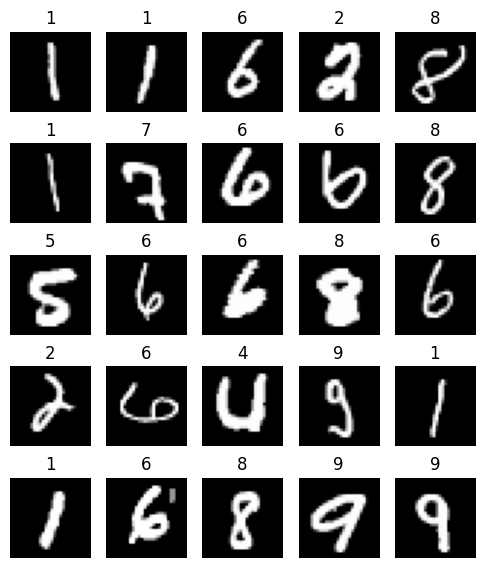

In [5]:
plt.figure(figsize=(6, 7))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.imshow(X[i].reshape(28, 28), cmap=plt.cm.Greys_r)
    plt.title(y[i])
    plt.axis('off')

#### Сначала реализуем инициализацию He (Как на семинаре):

$w_{i} \sim \mathcal{N}(0; \frac{2}{n_{in}})$

In [40]:
def init_layer_he(layer, mean=0, std=1):
    # Тут надо быть аккуратным — можно случайно создать копию и менять значения у копии
    weight = layer.state_dict()['weight']
    bias = layer.state_dict()['bias']
    bias.zero_()
    weight.normal_(mean=0, std=std)

def forward_hook_he(self, input_, output):
    std = input_[0].std().item()
    print('forward', std)

def backward_hook_he(self, grad_input, grad_output):
    std = grad_input[0].std().item()
    print('backward', std)

На вход передаем изображение 28x28, на выходе -- вероятности 10 классов.

In [43]:
layer_he_1 = nn.Linear(28*28, 500)
layer_he_2 = nn.Linear(500, 10)

layer_he_1.register_forward_hook(forward_hook_he)
layer_he_2.register_forward_hook(forward_hook_he)

layer_he_1.register_backward_hook(backward_hook_he)
layer_he_2.register_backward_hook(backward_hook_he)

init_layer_he(layer_he_1, 0.0, 2 / 784)
init_layer_he(layer_he_2, 0.0, 2 / 500)

Соберем все вместе, используя ReLU в качестве функции активации:

In [46]:
network_he = nn.Sequential(
    layer_he_1,
    nn.ReLU(),
    layer_he_2
)

In [53]:
n_objects = 100
X = images_train[:n_objects].view(n_objects, -1).data
y = labels_train[:n_objects].data
activations = network_he(X)
loss_fn = torch.nn.NLLLoss()
optimizer = torch.optim.Adam(network_he.parameters(), lr=0.001)
loss = loss_fn(activations, y)
loss.backward()

forward 0.9883414506912231
forward 0.04081486538052559
backward 0.034960296005010605
backward 0.0007811025716364384


#### 1.1 Реализуйте инициализацию Xavier. Сравните ее с He, которая была реализована на семинаре, сделайте выводы. Учтите, что для Xavier необходимо использовать функцию активации nn.Tanh(). **(1 балл)**

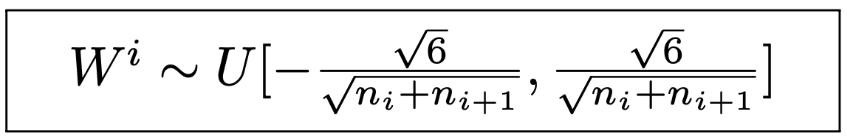

#### Логика

In [57]:
def init_layer_xavier_weights(layer):
    in_features = layer.in_features
    out_features = layer.out_features
    weights = layer.state_dict()['weight']
    bias = layer.state_dict()['bias']
    bias.zero_()
    weights.uniform_(6**0.5 / (in_features +  out_features)**0.5, 6**0.5 / (in_features + out_features)**0.5)

def forward_hook_xavier(self, input_, output):
    std = input_[0].std().item()
    print('forward', std)

def backward_hook_xavier(self, grad_input, grad_output):
    std = grad_input[0].std().item()
    print('backward', std)


#### Инициализация

In [60]:
layer_xavier_1 = nn.Linear(28*28, 500)
layer_xavier_2 = nn.Linear(500, 10)

layer_xavier_1.register_forward_hook(forward_hook_xavier)
layer_xavier_2.register_forward_hook(forward_hook_xavier)

layer_xavier_1.register_backward_hook(backward_hook_xavier)
layer_xavier_2.register_backward_hook(backward_hook_xavier)

init_layer_xavier_weights(layer_xavier_1)
init_layer_xavier_weights(layer_xavier_2)

#### Проверим: (nn.Tanh())

In [63]:
network_xavier = nn.Sequential(
    layer_xavier_1,
    nn.Tanh(),
    layer_xavier_2
)

In [65]:
n_objects = 100
X = images_train[:n_objects].view(n_objects, -1).data
y = labels_train[:n_objects].data
activations = network_xavier(X)
loss_fn = torch.nn.NLLLoss()
optimizer = torch.optim.Adam(network_xavier.parameters(), lr=0.001)
loss = loss_fn(activations, y)
loss.backward()

forward 0.9883414506912231
forward 0.9038040637969971
backward 0.034960296005010605
backward 0.0


#### Как мы видим, дисперсия выходов сбалансирована от выхода к выходу как в случае функции активации ReLU(), так и в случае функции активации Tanh(). Однако под капотом работают совершенно разные механизмы, поддерживая баланс дисперсии от слоя к слою.

#### 1. Так, например, при использовании функции активации Tanh() дисперсия выхода из слоя будет описываться формулой:

$Var(w^T x) = Var(x) \cdot Var(w) + \mathbb{E}[x]^2  \cdot Var(w) + \mathbb{E}[w]^2 \cdot Var(x)$

#### Инициализируя веса с нулевым средним и учитывая, что:

$\mathbb{E} [tanh(x)] = \int_{-\infty}^{+\infty} tanh(x) \cdot p(x) = 0$, поскольку интеграл произведения четной и нечетной функций (плотности вероятности и гиперболического тангенса) на симметричном отрезке будет равен нулю.

#### Таким образом, мы получим:

$Var(w^T x) = n_{in} \cdot Var(x) \cdot Var(w)$

#### Поэтому мы можем инициализировать распределение весов с дисперсией $\frac{1}{n_{in}}$. Дополнительно еще контролируется дисперсия градиентов при обратном распространении ошибки (там будет условие $Var(w) = \frac{1}{n_{out}}$), откуда и получается общая формула для распределения весов:

$w \sim U[-\frac{\sqrt{6}}{\sqrt{n_{in} + n_{out}}}; \frac{\sqrt{6}}{\sqrt{n_{in} + n_{out}}}]$

#### 2. Для активации ReLU() используется несколько иной пордход. Здесь для формулы дисперсии выхода уже нельзя просто так занулить матожидание функции активации, поэтому имеем формулу вида:

$Var(w^T x) = Var(w) \cdot (Var(x) + \mathbb{E} [x]^2)$

#### Находя матожидание $\mathbb{E} [y = ReLU(x)] = \frac{1}{2} Var(x)$ (Исходя их функции $ReLU(z) = max(0, z)$ и плотности вероятности по Гауссу), получим:

$Var(y) = \frac{1}{2} n_{in} Var(w) Var(x)$

#### Поэтому генерируем веса с распределением:

$w_{i} \sim \mathcal{N} (0, \frac{2}{n_{in}})$

#### Так, оба подхода балансируют дисперсию, но работают по-разному под капотом в зависимости от выбора архитектуры.

## Часть 2: DropConnect

#### 2.1 Реализуйте DropConnect по следующему шаблону: **(1 балл)**

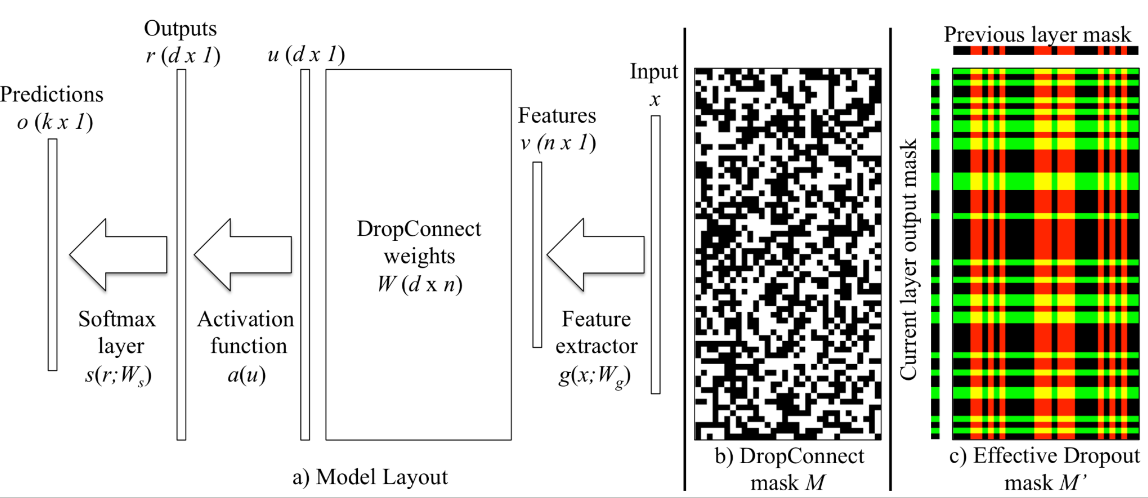

In [126]:
# полезная функция: .bernoulli_(p)
# не забывайте делать requires_grad=False у маски
# помните, что в вычислениях должны участвовать Variable, а не тензоры

class DropConnect(nn.Module):
    def __init__(self, input_dim, output_dim, p=0.5):
        super(DropConnect, self).__init__()
        self.linear = nn.Linear(input_dim, output_dim)
        self.p = p 
        
    def forward(self, x):
        if self.training:
            mask = 1.0 / (1.0 - self.p) * torch.empty_like(self.linear.weight).bernoulli_(self.p) 
            mask.requires_grad = False
        else:
            mask = torch.ones_like(self.linear.weight)

        mask = mask.data
        output = F.linear(x, self.linear.weight * mask, self.linear.bias)
        return output

#### Масштабирующий множитель $scale = \frac{1}{1 - p}$ используется для того, чтобы не менялось матожидание весовых коэффициентов после применения операции DropConnect. Пусть $p$ - вероятность "отключения" веса после применения операции DropСonnect, тогда $1 - p$ - вероятность "выживания" веса после применения операции. Тогда после применения DropConnect получим:

$\mathbb{E}[w_{new} = DropConnect(w)] = \frac{1}{1 - p} w \cdot(1 - p) + p \cdot 0 = w$

#### При инференсе модели веса не зануляем, поэтому и используется единичная маска.

#### Dropout:

In [256]:
class Dropout(nn.Module):
    def __init__(self, p=0.5):
        super(Dropout, self).__init__()
        self.p = p

    def forward(self, x):
        mask = torch.empty(x.shape).uniform_(0, 1).type(torch.FloatTensor)
        if self.training:
            mask = 1.0 / (1.0 - self.p) * torch.where(mask > self.p, 1, 0)
            mask.requires_grad = False
        else:
            mask = torch.where(mask > self.p, 1, 1 - self.p)

        return x * mask

#### Масштабирующий множитель $scale = \frac{1}{1 - p}$ используется, чтобы не менять матожидание выхода после применения операции Dropout. Пусть $p$ - вероятность "отключения" нейрона после применения операции Dropout, тогда $1 - p$ - вероятность "выживания" нейрона после применения операции. Тогда после применения Dropout получим:

$\mathbb{E}[y = Dropout(x)] = \frac{1}{1 - p} x \cdot(1 - p) + p \cdot 0 = x$

#### [Яндекс "Тонкости Обучения"](https://education.yandex.ru/handbook/ml/article/tonkosti-obucheniya)

Основа для сетей, которые будем обучать:

In [6]:
class TestNetwork(nn.Module):
    def __init__(self, final_part):
        super().__init__()

        channels = 1

        self.conv_layers = nn.Sequential(
            nn.Conv2d(channels, 2, 3, padding=1),
            nn.MaxPool2d(2),
            nn.ReLU(),
            nn.Conv2d(2, 4, 3, padding=1),
            nn.MaxPool2d(2),
            nn.ReLU(),
        )

        #input_size = 7 * 7 * 4 = 196
        self.flatten = nn.Flatten()

        self.final_part = final_part

        self.log_softmax = nn.LogSoftmax(1)

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.flatten(x)
        x = self.final_part(x)
        return self.log_softmax(x)

Добавим несколько слоев в конец сетей:

In [263]:
layers_dropconnect = [
    DropConnect(input_dim = 196, output_dim = 128),
    nn.ReLU(),
    DropConnect(input_dim = 128, output_dim = 128),
    nn.ReLU(),
    DropConnect(input_dim = 128, output_dim = 10),
]

In [265]:
layers_dropout = [
    nn.Linear(196, 128),
    nn.ReLU(),
    Dropout(),
    nn.Linear(128, 128),
    nn.ReLU(),
    Dropout(),
    nn.Linear(128, 10)
]

In [267]:
network_dropout = TestNetwork(nn.Sequential(*layers_dropout))
optimizer_dropout = torch.optim.Adam(network_dropout.parameters(), lr=0.001)
loss_dropout_fn = torch.nn.NLLLoss()

network_dropconnect = TestNetwork(nn.Sequential(*layers_dropconnect))
optimizer_dropconnect = torch.optim.Adam(network_dropconnect.parameters(), lr=0.001)
loss_dropconnect_fn = torch.nn.NLLLoss()

Обучим получившиеся сети:

In [7]:
def network_fit(network, optimizer, loss_fn, epochs = 5):
    
    losses_train = []
    losses_test = []
    
    for epoch in range(epochs):
        network.train()
        losses_train_tmp = []
        for batch_idx, (images_train, labels_train) in enumerate(train_loader):
            optimizer.zero_grad()
            X = images_train.data
            y = labels_train.data
            output = network(X)
            loss = loss_fn(output, y)
            loss.backward()
            optimizer.step()
            losses_train_tmp.append(loss.item())
    
            # if batch_idx % 100 == 0:
            #     print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
            #     epoch, batch_idx * len(X), len(train_loader.dataset),
            #     100. * batch_idx / len(train_loader), loss.item()))
        print('Train Epoch: {}\tLoss: {:.6f}'.format(
                epoch, np.mean(losses_train_tmp)))

        losses_train.append(np.mean(losses_train_tmp))
    
        network.eval()
        losses_test_tmp = []
        for batch_idx, (images_test, labels_test) in enumerate(test_loader):
            X = images_test.data
            y = labels_test.data
            output = network(X)
            loss = loss_fn(output, y)
    
            losses_test_tmp.append(loss.item())
    
        print('Test Epoch: {}\tLoss: {:.6f}'.format(
                epoch, np.mean(losses_test_tmp)))
        losses_test.append(np.mean(losses_test_tmp))
        print()
        
    return losses_train, losses_test


#### Dropout fit:

In [273]:
dropout_losses_train, dropout_losses_test = network_fit(network_dropout, optimizer_dropout, loss_dropout_fn, epochs = 10)

Train Epoch: 0	Loss: 0.763390
Test Epoch: 0	Loss: 0.344780

Train Epoch: 1	Loss: 0.300624
Test Epoch: 1	Loss: 0.242279

Train Epoch: 2	Loss: 0.227430
Test Epoch: 2	Loss: 0.180350

Train Epoch: 3	Loss: 0.198543
Test Epoch: 3	Loss: 0.157646

Train Epoch: 4	Loss: 0.175002
Test Epoch: 4	Loss: 0.144214

Train Epoch: 5	Loss: 0.159078
Test Epoch: 5	Loss: 0.124848

Train Epoch: 6	Loss: 0.147557
Test Epoch: 6	Loss: 0.116383

Train Epoch: 7	Loss: 0.139729
Test Epoch: 7	Loss: 0.116420

Train Epoch: 8	Loss: 0.133156
Test Epoch: 8	Loss: 0.099906

Train Epoch: 9	Loss: 0.127358
Test Epoch: 9	Loss: 0.094529



#### DropConnect fit:

In [275]:
dropconnect_losses_train, dropconnect_losses_test = network_fit(network_dropconnect, optimizer_dropconnect, loss_dropconnect_fn, epochs = 10)

Train Epoch: 0	Loss: 0.958969
Test Epoch: 0	Loss: 0.238836

Train Epoch: 1	Loss: 0.343849
Test Epoch: 1	Loss: 0.153859

Train Epoch: 2	Loss: 0.253550
Test Epoch: 2	Loss: 0.131420

Train Epoch: 3	Loss: 0.213499
Test Epoch: 3	Loss: 0.106205

Train Epoch: 4	Loss: 0.185454
Test Epoch: 4	Loss: 0.097102

Train Epoch: 5	Loss: 0.169623
Test Epoch: 5	Loss: 0.086956

Train Epoch: 6	Loss: 0.154771
Test Epoch: 6	Loss: 0.082978

Train Epoch: 7	Loss: 0.149211
Test Epoch: 7	Loss: 0.083183

Train Epoch: 8	Loss: 0.140792
Test Epoch: 8	Loss: 0.073494

Train Epoch: 9	Loss: 0.134168
Test Epoch: 9	Loss: 0.078868




#### 2.2 Сравните графики обучения нейроных сетей **(1 балл)**:
1. Свертки из TestNetwork -> 128 -> 128 -> 10 с ReLU и Dropout между всеми слоями
2. Свертки из TestNetwork -> 128 -> 128 -> 10 с ReLU и DropConnect вместо всех линейных слоев


#### Сравним сходимости моделей DropConnect и Dropout на train и test выборках

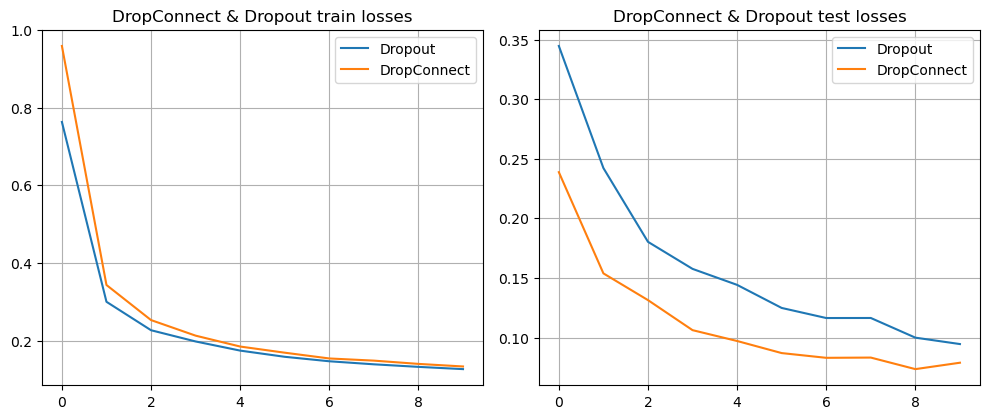

In [278]:
epochs = np.arange(0, 10, 1)

figure = plt.figure(figsize = (10, 8))

# train
figure.add_subplot(2, 2, 1)
plt.plot(epochs, dropout_losses_train, label = 'Dropout')
plt.plot(epochs, dropconnect_losses_train, label = 'DropConnect')
plt.title('DropConnect & Dropout train losses')
plt.legend()
plt.grid()

figure.add_subplot(2, 2, 2)
plt.plot(epochs, dropout_losses_test, label = 'Dropout')
plt.plot(epochs, dropconnect_losses_test, label = 'DropConnect')
plt.title('DropConnect & Dropout test losses')
plt.legend()
plt.grid()


plt.tight_layout()
plt.show()


#### Мы видим, что на train выборке loss ниже при использовании Dropout, однако при инференсе модели потери ниже при использовании DropConnect

#### Скорее всего, это может быть связано с тем, что при обучении у Dropout происходит отключение на уровне нейронов, а не весов. Поэтому веса остаются стабильными и хорошо обученными под разные представления тренировочных данных. Напротив, DropConnect подразумевает меньшую стабильность весов при обучении модели, по сути генерируя отдельные модели с разными параметрами, которые в среднем при инференсе дают высокую точность. DropConnect чем-то в этом смысле напоминает случайные леса, когда мы строим много переобученных деревьев, усредняя их предсказания при инференсе.

### Часть 3: Batch Normalization

Наконец, давайте рассмотрим Batch Normalization. Этот слой вычитает среднее и делит на стандартное отклонение. Среднее и дисперсия вычисляются по батчу независимо для каждого нейрона. У этого слоя есть две важные проблемы: его нельзя использовать при обучении с размером батча 1 и он делает элементы батча зависимыми. Давайте реализуем аналог батч нормализации: <a href=https://arxiv.org/pdf/1607.06450.pdf>Layer normalization</a>. В layer normalization среднее и дисперсия вычисляются по активациям нейронов, независимо для каждого объекта.

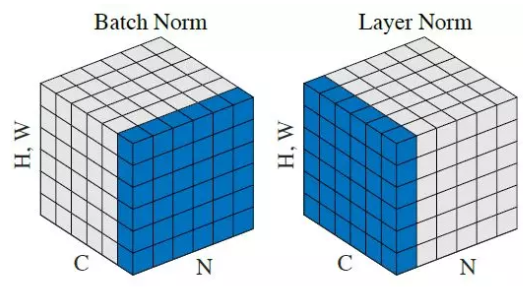

#### \* Тренировочный полигон \*

In [8]:
batch_tmp = torch.rand(2, 2, 2, 2)
epsilon_tmp = 1e-5

In [9]:
batch_tmp.size()

torch.Size([2, 2, 2, 2])

In [10]:
mu = batch_tmp.mean(dim = [0, 2, 3], keepdim = True)
var = batch_tmp.var(dim = [0, 2, 3], unbiased = False, keepdim = True)

In [11]:
batch_normalized = (batch_tmp - mu) / torch.sqrt(var + epsilon_tmp)

norm = nn.BatchNorm2d(2)
batch_normalized_nn = norm(batch_tmp)

In [12]:
batch_normalized

tensor([[[[ 0.4372, -1.1670],
          [ 1.5005,  0.8272]],

         [[-0.7875,  0.3997],
          [ 1.3518,  0.5785]]],


        [[[-0.9691, -0.0547],
          [-1.3833,  0.8092]],

         [[-1.3607, -0.4141],
          [-1.1101,  1.3424]]]])

In [13]:
batch_normalized_nn

tensor([[[[ 0.4372, -1.1670],
          [ 1.5005,  0.8272]],

         [[-0.7875,  0.3997],
          [ 1.3518,  0.5785]]],


        [[[-0.9691, -0.0547],
          [-1.3833,  0.8092]],

         [[-1.3607, -0.4141],
          [-1.1101,  1.3424]]]], grad_fn=<NativeBatchNormBackward0>)

In [16]:
batch_norm2d_instance = BatchNormalization2d(2) # Класс реализован впереди
output_custom_batch_norm2d = batch_norm2d_instance(batch_tmp)
print(output_custom_batch_norm2d)

tensor([[[[ 0.4372, -1.1670],
          [ 1.5005,  0.8272]],

         [[-0.7875,  0.3997],
          [ 1.3518,  0.5785]]],


        [[[-0.9691, -0.0547],
          [-1.3833,  0.8092]],

         [[-1.3607, -0.4141],
          [-1.1101,  1.3424]]]], grad_fn=<AddBackward0>)


In [17]:
batch_tmp = torch.randn(2, 3)
mu = batch_tmp.mean(dim = 0, keepdim = True)
var = batch_tmp.var(dim = 0, unbiased = False, keepdim = True)

print(batch_tmp)
print(mu)
print(var)

tensor([[ 0.3639,  0.2166, -2.0227],
        [-0.7129,  2.1246,  0.1892]])
tensor([[-0.1745,  1.1706, -0.9167]])
tensor([[0.2899, 0.9100, 1.2231]])


#### Работает корректно, теперь делаем реализацию BatchNormalization

In [15]:
class BatchNormalization2d(nn.Module):
    def __init__(self, out_features, epsilon=1e-5, momentum=0.1):
        super(BatchNormalization2d, self).__init__()
        self.out_features = out_features
        self.epsilon = epsilon
        self.momentum = momentum
        self.alpha = torch.ones(out_features, requires_grad = True)  # scaling parameters
        self.beta = torch.zeros(out_features, requires_grad = True)  # shift parameters
        self.register_buffer('mu_star', torch.zeros(out_features))
        self.register_buffer('var_star', torch.ones(out_features))

    def forward(self, x):
        if self.training:
            batch_mu = x.mean(dim=[0, 2, 3], keepdim=True)
            batch_var = x.var(dim=[0, 2, 3], unbiased=False, keepdim=True)

            self.mu_star = self.mu_star * self.momentum + (1 - self.momentum) * batch_mu.squeeze()
            self.var_star = self.var_star * self.momentum + (1 - self.momentum) * batch_var.squeeze()

            mu = batch_mu
            var = batch_var
        else:
            mu = self.mu_star.view(1, -1, 1, 1)
            var = self.var_star.view(1, -1, 1, 1)

        x_normalized_step = (x - mu) / (torch.sqrt(var + self.epsilon))
        x_normalized = self.alpha.view(1, -1, 1, 1) * x_normalized_step + self.beta.view(1, -1, 1, 1)

        return x_normalized

class BatchNormalization1d(nn.Module):
    def __init__(self, out_features, epsilon=1e-5, momentum=0.1):
        super(BatchNormalization1d, self).__init__()
        self.out_features = out_features
        self.epsilon = epsilon
        self.momentum = momentum
        self.alpha = torch.ones(out_features, requires_grad = True)  # scaling parameters
        self.beta = torch.zeros(out_features, requires_grad = True)  # shift parameters
        self.register_buffer('mu_star', torch.zeros(out_features))
        self.register_buffer('var_star', torch.ones(out_features))

    def forward(self, x):
        if self.training:
            batch_mu = x.mean(dim=0, keepdim=True)
            batch_var = x.var(dim=0, unbiased=False, keepdim=True)

            self.mu_star = self.mu_star * self.momentum + (1 - self.momentum) * batch_mu.squeeze()
            self.var_star = self.var_star * self.momentum + (1 - self.momentum) * batch_var.squeeze()

            mu = batch_mu
            var = batch_var
        else:
            mu = self.mu_star.view(1, -1)
            var = self.var_star.view(1, -1)

        x_normalized_step = (x - mu) / (torch.sqrt(var + self.epsilon))
        x_normalized = self.alpha.view(1, -1) * x_normalized_step + self.beta.view(1, -1)

        return x_normalized

#### 3.1 Реализуйте Layer Normalization **(1 балл)**

#### \* Тренировочный полигон \*

In [18]:
batch_tmp = torch.rand(2, 3, 1, 1)
epsilon_tmp = 1e-5

# print(batch_tmp)

mu = batch_tmp.mean(dim = [1, 2, 3], keepdim = True)
var = batch_tmp.var(dim = [1, 2, 3], keepdim = True)

layer_norm_tmp = (batch_tmp - mu) / torch.sqrt(var + epsilon_tmp)

# print(mu)
# print(var)

print(layer_norm_tmp.size())

# layer_norm = nn.LayerNorm(batch_tmp.size()[1:])(batch_tmp)

# print(layer_norm)


torch.Size([2, 3, 1, 1])


In [19]:
class LayerNormalization(nn.Module):
    def __init__(self, out_features, epsilon=1e-5, dim=2):
        super(LayerNormalization, self).__init__()
        self.epsilon = epsilon
        self.alpha = nn.Parameter(torch.ones(out_features))  # scaling parameters
        self.beta = nn.Parameter(torch.zeros(out_features))  # shift parameters
        self.dim = dim

    def forward(self, x):
        if self.dim == 1:
            layer_mu = x.mean(dim=-1, keepdim=True)
            layer_var = x.var(dim=-1, unbiased=False, keepdim=True)
        elif self.dim == 2:
            layer_mu = x.mean(dim=[1, 2, 3], keepdim=True)
            layer_var = x.var(dim=[1, 2, 3], unbiased=False, keepdim=True)

        x_normalized_step = (x - layer_mu) / (torch.sqrt(layer_var + self.epsilon))
        x_normalized = self.alpha * x_normalized_step + self.beta

        return x_normalized


#### 3.2 Сравните графики обучения нейроных сетей **(1 балл)**:
1. Свертки из TestNetwork -> 128 -> 128 -> 10 с ReLU и Batch normalization между всеми слоями
2. Свертки из TestNetwork -> 128 -> 128 -> 10 с ReLU и Layer normalization между всеми слоями

#### Свёрточная сеть с использованием BatchNormalization 

In [20]:
class TestNetworkNorm(TestNetwork):
    def __init__(self, final_part, convolution_layers):
        super(TestNetworkNorm, self).__init__(final_part)
        self.conv_layers = convolution_layers
    

In [29]:
fully_connected_layers_batch_norm = [
    nn.Linear(196, 128),
    nn.ReLU(),
    BatchNormalization1d(128),
    nn.Linear(128, 128),
    nn.ReLU(),
    BatchNormalization1d(128),
    nn.Linear(128, 10)
]

fully_connected_layers_layer_norm = [
    nn.Linear(196, 128),
    nn.ReLU(),
    LayerNormalization(128, dim = 1),
    nn.Linear(128, 128),
    nn.ReLU(),
    LayerNormalization(128, dim = 1),
    nn.Linear(128, 10)
]

convolution_layers_batch_norm = [
            nn.Conv2d(1, 2, 3, padding=1),
            nn.MaxPool2d(2),
            nn.ReLU(),
            BatchNormalization2d(2),
    
            nn.Conv2d(2, 4, 3, padding=1),
            nn.MaxPool2d(2),
            nn.ReLU(),
            BatchNormalization2d(4),
        ]

convolution_layers_layer_norm = [
            nn.Conv2d(1, 2, 3, padding=1),
            nn.MaxPool2d(2),
            nn.ReLU(),
            LayerNormalization((2, 14, 14)),
    
            nn.Conv2d(2, 4, 3, padding=1),
            nn.MaxPool2d(2),
            nn.ReLU(),
            LayerNormalization((4, 7, 7)),
        ]

batch_norm_network = TestNetworkNorm(nn.Sequential(*fully_connected_layers_batch_norm), 
                                     nn.Sequential(*convolution_layers_batch_norm))
layer_norm_network = TestNetworkNorm(nn.Sequential(*fully_connected_layers_layer_norm), 
                                     nn.Sequential(*convolution_layers_layer_norm))

optimizer_batch_norm = torch.optim.Adam(batch_norm_network.parameters(), lr=0.001)
optimizer_layer_norm = torch.optim.Adam(layer_norm_network.parameters(), lr=0.001)

loss_batch_norm_fn = torch.nn.NLLLoss()
loss_layer_norm_fn = torch.nn.NLLLoss()

In [30]:
losses_batch_norm_train, losses_batch_norm_test = network_fit(batch_norm_network, 
                                                              optimizer_batch_norm,
                                                              loss_batch_norm_fn, 
                                                              epochs = 10)

Train Epoch: 0	Loss: 0.237017
Test Epoch: 0	Loss: 0.101222

Train Epoch: 1	Loss: 0.087567
Test Epoch: 1	Loss: 0.078741

Train Epoch: 2	Loss: 0.067724
Test Epoch: 2	Loss: 0.082265

Train Epoch: 3	Loss: 0.056840
Test Epoch: 3	Loss: 0.076454

Train Epoch: 4	Loss: 0.048879
Test Epoch: 4	Loss: 0.069352

Train Epoch: 5	Loss: 0.042632
Test Epoch: 5	Loss: 0.068284

Train Epoch: 6	Loss: 0.038276
Test Epoch: 6	Loss: 0.062399

Train Epoch: 7	Loss: 0.033512
Test Epoch: 7	Loss: 0.137260

Train Epoch: 8	Loss: 0.031094
Test Epoch: 8	Loss: 0.068701

Train Epoch: 9	Loss: 0.027196
Test Epoch: 9	Loss: 0.069020



In [31]:
losses_layer_norm_train, losses_layer_norm_test = network_fit(layer_norm_network, 
                                                              optimizer_layer_norm,
                                                              loss_layer_norm_fn, 
                                                              epochs = 10)

Train Epoch: 0	Loss: 0.232183
Test Epoch: 0	Loss: 0.087966

Train Epoch: 1	Loss: 0.081559
Test Epoch: 1	Loss: 0.073341

Train Epoch: 2	Loss: 0.056442
Test Epoch: 2	Loss: 0.063313

Train Epoch: 3	Loss: 0.043509
Test Epoch: 3	Loss: 0.056267

Train Epoch: 4	Loss: 0.033565
Test Epoch: 4	Loss: 0.048669

Train Epoch: 5	Loss: 0.026770
Test Epoch: 5	Loss: 0.061302

Train Epoch: 6	Loss: 0.021852
Test Epoch: 6	Loss: 0.060979

Train Epoch: 7	Loss: 0.020156
Test Epoch: 7	Loss: 0.054630

Train Epoch: 8	Loss: 0.017184
Test Epoch: 8	Loss: 0.061392

Train Epoch: 9	Loss: 0.012940
Test Epoch: 9	Loss: 0.058512



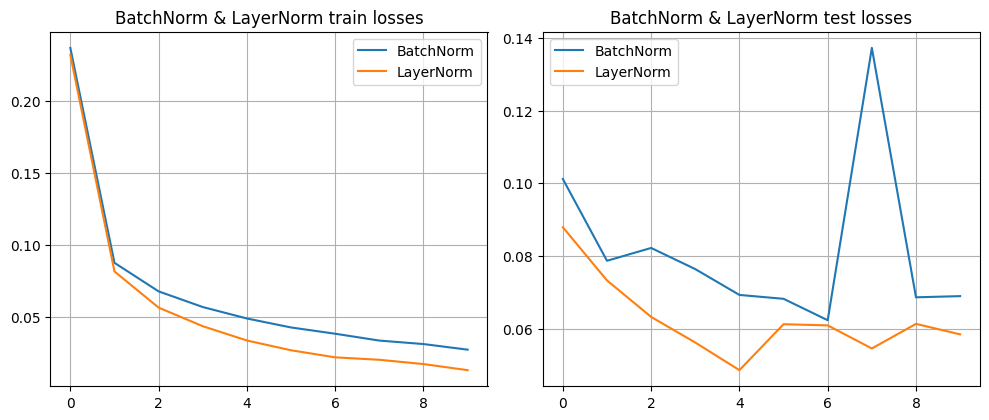

In [32]:
epochs = np.arange(0, 10, 1)

figure = plt.figure(figsize = (10, 8))

# train
figure.add_subplot(2, 2, 1)
plt.plot(epochs, losses_batch_norm_train, label = 'BatchNorm')
plt.plot(epochs, losses_layer_norm_train, label = 'LayerNorm')
plt.title('BatchNorm & LayerNorm train losses')
plt.legend()
plt.grid()

figure.add_subplot(2, 2, 2)
plt.plot(epochs, losses_batch_norm_test, label = 'BatchNorm')
plt.plot(epochs, losses_layer_norm_test, label = 'LayerNorm')
plt.title('BatchNorm & LayerNorm test losses')
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()

#### Здесь мы видим, что ошибка на train и test выборках ниже в случае Layer Normalization в сравнеии с Batch Normalization. Полагаю, что это связано с тем, что при нормализации по батчу усреднение по каждому каналу происходит внутри выборки сэмплов на этапе обучения и каждый сэмпл в какой-то степени заимствует информацию от других сэмплов (а они могут и шумовыми быть). В этом смысле и теряется некоторая степень обощающей способности модели. Плюс еще при инференсе используются по сути те $\mu$ и $\sigma^{2}$, которые были получены из тренировочной выборки.

#### Layer Normalization, напротив, не берет никакой информации из других элементов батча как на этапе обучения, так и на этапе инференса, усредняя информацию внутри каждого сэмпла. Вероятно, именно этот факт придает стабильности обучению.